In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle

from settings import AMBIGUITY_PATH, AMBIGUITY_VARIATION
from src.analysis.embedded import calculate_vocabulary_variation, embedded_CIs
from src.analysis.entropy import get_emoji_entropy
from src.data.utils import parallelize_dataframe

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
sns.set_style("white", {'axes.grid' : False})

In [3]:
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)

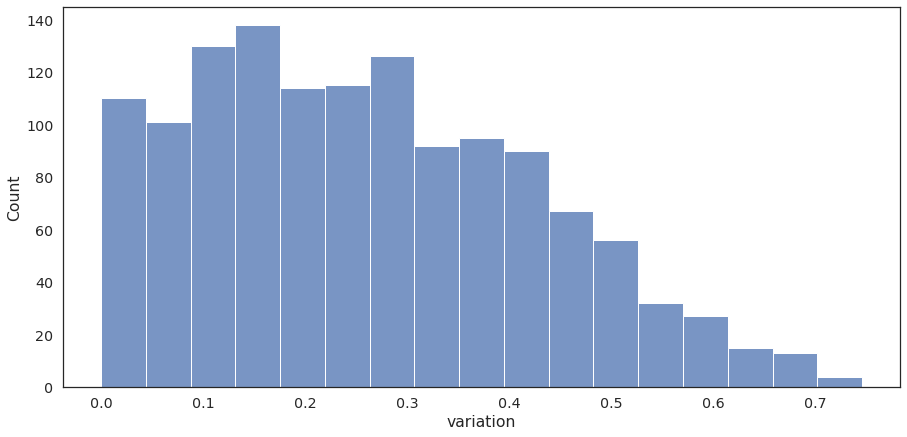

In [4]:
sns.histplot(data=variations.variation);

In [5]:
variations.describe()

,variation
count,1325.000000
mean,0.262528
std,0.164641
min,0.000000
25%,0.128927
50%,0.247732
75%,0.383371
max,0.745275


In [6]:
median_mask = variations.variation.sub(variations.variation.median()).abs().lt(0.001)
median_indices = median_mask[median_mask == True].index
print("Median emojis:")
print(variations.iloc[median_indices].emoji)

Median emojis:
307     🍬
514     👄
763     📰
817     🔧
947     😹
1238    🦸
Name: emoji, dtype: object


In [7]:
mean_mask = variations.variation.sub(variations.variation.mean()).abs().lt(0.001)
mean_indices = mean_mask[mean_mask == True].index
print("Mean emojis:")
print(variations.iloc[mean_indices].emoji)

Mean emojis:
35      ▪️
83      ♾️
314      🍳
408     🏘️
898      😈
1084     🤓
Name: emoji, dtype: object


## Check faces and gestures

In [8]:
faces_gestures = ["✊","✋","👆","👇","👈","👉","👊","👋","👌","👍","👎","👏","👐",
                 "😀", "😁", "😂", "😃", "😄","😅", "😆", "😇", "😈", "😉", "😊", "😋",
                 "😌","😍","😎","😏","😐","😑","😒","😓","😔","😕","😖","😗","😘","😙",
                 "😚","😛","😜","😝","😞","😟","😠","😡","😢","😣","😤","😥","😦","😧",
                 "😨","😩","😪","😫","😬","😭","😮","😯","😰","😱","😲","😳","😴","😵",
                 "😶","😷","😸","😹","😺","😻","😼","😽","😾","😿","🙀","🙁","🙂","🙃",
                 "🙄", "🙌", "🙏", "🤐","🤑","🤒","🤓","🤔","🤕","🤗","🤘","🤙","🤚",
                 "🤛","🤜","🤝","🤞","🤟","🤢","🤣","🤤","🤥","🤦","🤧","🤨","🤩","🤪",
                 "🤫","🤬","🤭","🤮","🤯","🤲","🥰","🥱","🥳","🥴","🥵","🥶","🥺","🧐",
                 "🤝‍","☹️","☺️","✊","✋","✌️", "🖐️","🖕","🖖", "🤐","🤑","🤒","🤓",
                 "🤔","🤕","🤗","🤘","🤙","🤚","🤛","🤜","🤝","🤞","🤟","🤠", '☹', '👿']

In [9]:
variations[variations.emoji.isin(faces_gestures)].sort_values("variation")[:10]

,emoji,vocabulary,variation,CIs
922,😠,"Counter({'angry': 23, 'mad': 1, 'unhappy': 1})",0.035486,"[0.0, 0.09324674129486084]"
129,✌️,"Counter({'peace': 25, 'TRUE': 1, 'relax': 1, '...",0.069838,"[0.01840295592943827, 0.1396838635454575]"
949,😻,"Counter({'love': 25, 'inlove': 2, 'happy': 1, ...",0.080351,"[0.01833237012227376, 0.15768711941937605]"
948,😺,"Counter({'cat': 24, 'happy': 2, 'chat': 1, 'ca...",0.095881,"[0.027669954916526532, 0.1801161047071218]"
1175,🥰,"Counter({'love': 19, 'happy': 2, 'loving': 1, ...",0.106312,"[0.0414176274228979, 0.17475930383359944]"
920,😞,"Counter({'sad': 23, 'tired': 3, 'frown': 1, 'd...",0.111193,"[0.03698620746533076, 0.20277523578455048]"
522,👌,"Counter({'ok': 12, 'okay': 12, 'super': 3, 'go...",0.127271,"[0.06304978296674532, 0.1926774840930412]"
525,👏,"Counter({'clap': 23, 'applause': 3, 'applaud':...",0.133750,"[0.049102230866750085, 0.23317102633416653]"
955,🙁,"Counter({'sad': 21, 'frown': 3, 'sad face': 1,...",0.133778,"[0.04822632830057825, 0.23081580975225993]"
62,☹️,"Counter({'sad': 23, 'frown': 5, 'sad face': 1,...",0.143471,"[0.05125868221124013, 0.2563762262463569]"


In [10]:
variations[variations.emoji.isin(faces_gestures)].sort_values("variation", ascending=False)[:10]

,emoji,vocabulary,variation,CIs
1260,🧐,"Counter({'monocle': 6, 'searching': 2, 'curiou...",0.694345,"[0.5405628290023365, 0.7620357323158934]"
523,👍,"Counter({'thumbsup': 8, 'good': 6, 'like': 4, ...",0.659305,"[0.35942323507120205, 0.7137757058860733]"
934,😬,"Counter({'yikes': 4, 'scared': 3, 'smile': 2, ...",0.606156,"[0.4156691019733746, 0.7539479739131638]"
524,👎,"Counter({'no': 6, 'thumbsdown': 5, 'bad': 5, '...",0.603726,"[0.41508596424745126, 0.8211716933370296]"
912,😖,"Counter({'sour': 4, 'angry': 3, 'pain': 2, 'di...",0.599204,"[0.3985637224350985, 0.6864090398885312]"
863,🖖,"Counter({'vulcan': 8, 'hand': 4, 'peace': 4, '...",0.595715,"[0.4530712304058774, 0.675390723482545]"
906,😐,"Counter({'neutral': 8, 'meh': 4, 'sad': 3, 'fr...",0.570245,"[0.4463977318257093, 0.6580843109699588]"
944,😶,"Counter({'silent': 4, 'speechless': 3, 'surpri...",0.540968,"[0.4105328439663237, 0.7128576631210028]"
1106,🤩,"Counter({'starstruck': 10, 'happy': 2, 'smile'...",0.528141,"[0.38899610958479597, 0.6626359180515181]"
902,😌,"Counter({'satisfied': 5, 'happy': 5, 'pleased'...",0.521274,"[0.3911660198494792, 0.5699052496875323]"


In [11]:
variations[variations.emoji.isin(faces_gestures)].describe()

,variation
count,130.000000
mean,0.321350
std,0.133545
min,0.035486
25%,0.225858
50%,0.319662
75%,0.401400
max,0.694345


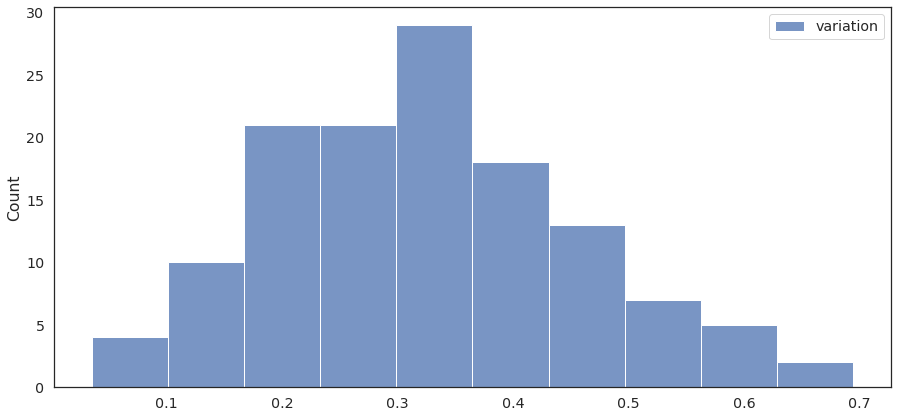

In [12]:
sns.histplot(data=variations[variations.emoji.isin(faces_gestures)], bins='doane');

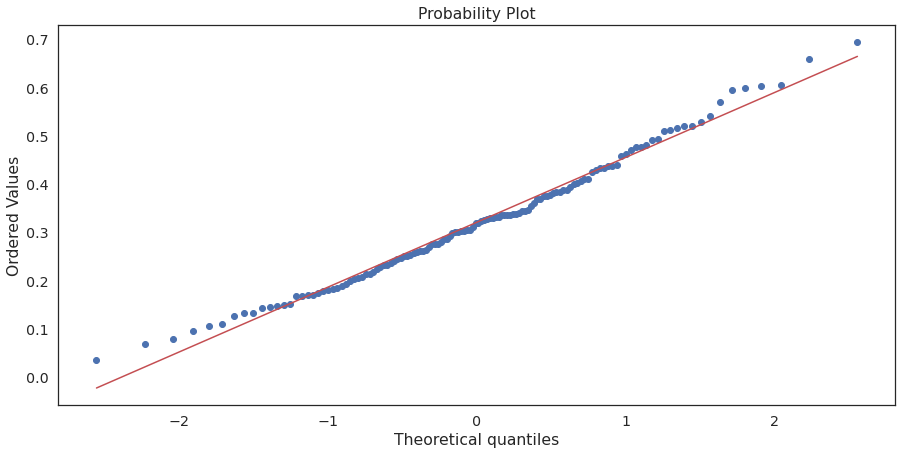

In [13]:
measurements = np.random.normal(loc=20, scale=5, size=100)   
stats.probplot(variations[variations.emoji.isin(faces_gestures)].variation, dist="norm", plot=plt);

## Check variation vs mean duration

In [14]:
emojis = pd.read_csv(AMBIGUITY_PATH)

In [15]:
variations = variations.set_index("emoji")
variations["mean_duration"] = emojis.groupby("emoji").Duration.sum() / emojis.groupby("emoji").WorkerID.count()

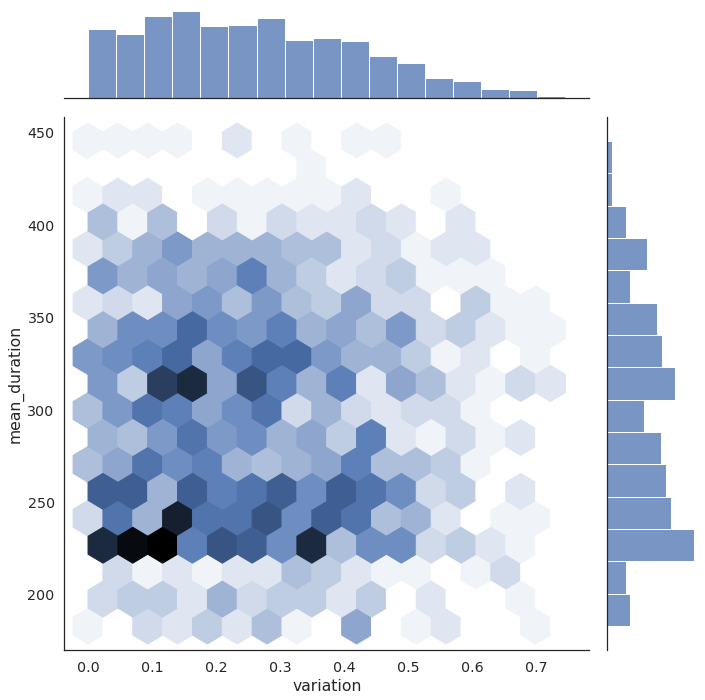

In [16]:
sns.jointplot(data=variations, x='variation', y='mean_duration', kind='hex', height=10);

### Variation vs entropy

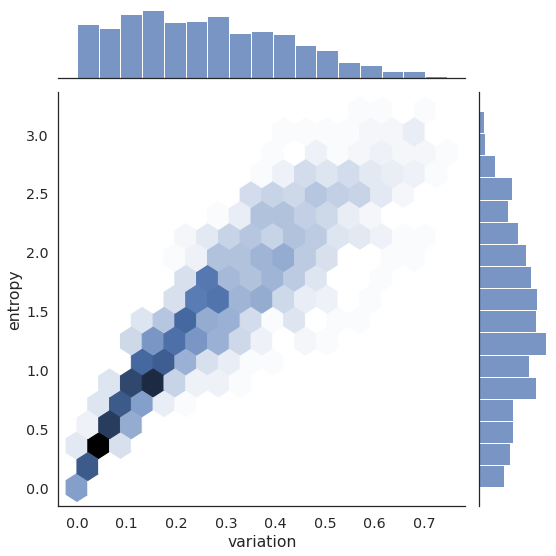

In [17]:
variations.vocabulary = [eval(el) for el in variations.vocabulary.tolist()]
variations["entropy"] = variations.vocabulary.apply(get_emoji_entropy)
sns.jointplot(data=variations, x='variation', y='entropy', kind='hex', height=8);